In [3]:
import random
import networkx as nx
import torch

from deep_ebm.utils_ebm import show_graph, evaluate_model
from deep_ebm.utils_ebm import save_graph, compare_graphs, show_graph_grid, compare_statistics
from deep_ebm.gnn_ebm import GraphDataset, GNN_EBM, train_one_epoch_pcd, gibbs_ministeps

from Plots_and_utils.plots import *
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

device = torch.device("cpu")

In [ ]:
with open("data/30IEEE_synth_dataset/reduced_30IEEE_synth_list_netX.pkl", "rb") as f:
    netX_30IEEE = pkl.load(f)

with open("data/2community_dataset/2comms_list_netX.pkl", "rb") as f:
    netX_2community  = pkl.load(f)

with open("data/Tree30_dataset/Tree30_list_netX.pkl", "rb") as f:
    netX_tree30  = pkl.load(f)

In [5]:

with open("Saved_models/2community_GNN_EBM_50epochs.pkl", "rb") as f:
    model_2community = pkl.load(f)

with open("Saved_models/30IEEE_GNN_EBM_30epochs.pkl", "rb") as f:
    model_30IEEE_30epochs = pkl.load(f)

with open("Saved_models/30IEEE_GNN_EBM_50epochs_200GS.pkl", "rb") as f:
    model_30IEEE_50epochs_200GS = pkl.load(f)

with open("Saved_models/tree30_GNN_EBM_30epochs.pkl", "rb") as f:
    model_tree = pkl.load(f)

In [6]:
# label 1 for 30IEEE
# label 2 for 2community
# label 3 for tree30

data1 = GraphDataset(netX_30IEEE)
data2 = GraphDataset(netX_2community)
data3 = GraphDataset(netX_tree30)

len(data1), len(data2), len(data3)

(350, 200, 200)

In [7]:
def get_embeddings(model, data1,data2,data3):
    complessive_energy = []

    for g in data1:
        adj = g[0]
        feats = g[1]
        energy = model(feats, adj).item()
        complessive_energy.append( (energy, 1) )
    for g in data2:
        adj = g[0]
        feats = g[1]
        energy = model(feats, adj).item()
        complessive_energy.append( (energy, 2) )
    for g in data3:
        adj = g[0]
        feats = g[1]
        energy = model(feats, adj).item()
        complessive_energy.append( (energy, 3) )
    
    return complessive_energy

In [8]:
complessive_energy_model_tree = get_embeddings(model_tree, data1, data2, data3)
complessive_energy_model_30IEEE_30epochs = get_embeddings(model_30IEEE_30epochs, data1, data2, data3)
complessive_energy_model_30IEEE_50epochs_200GS = get_embeddings(model_30IEEE_50epochs_200GS, data1, data2, data3)
complessive_energy_model_2community = get_embeddings(model_2community, data1, data2, data3)

In [18]:
def plot_embeddings(complessive_energy, title):
    labels_name = {1: "30IEEE", 2: "2community", 3: "tree30"}
    
    energies_by_label = {1: [], 2: [], 3: []}
    for e, l in complessive_energy:
        energies_by_label[l].append(e)

    colors = {1: "tab:blue", 2: "tab:orange", 3: "tab:green"}

    plt.figure(figsize=(8,5))

    for label in [1, 2, 3]:
        data = np.array(energies_by_label[label])
        kde = gaussian_kde(data, bw_method=0.1)
        x_vals = np.linspace(min(data), max(data), 200)
        y_vals = kde(x_vals)
        y_vals /= y_vals.sum()  
        plt.fill_between(x_vals, y_vals, alpha=0.3, color=colors[label], label=f"{labels_name[label]}")
        plt.plot(x_vals, y_vals, color=colors[label])

    plt.xlabel("Model prediction")
    plt.ylabel("Proportion (normalization based on class)")
    plt.title(title)
    plt.legend()
    plt.show()


In [21]:
def plot_embeddings_hist(complessive_energy, title, bins=30, xlim=None):
    labels_name = {1: "30IEEE", 2: "2community", 3: "tree30"}
    
    energies_by_label = {1: [], 2: [], 3: []}
    for e, l in complessive_energy:
        energies_by_label[l].append(e)

    colors = {1: "tab:blue", 2: "tab:orange", 3: "tab:green"}

    plt.figure(figsize=(8,5))

    for label in [1, 2, 3]:
        data = np.array(energies_by_label[label])
        # density=True → normalizza in modo che l'area sia 1 (per confrontare le forme)
        plt.hist(data, bins=bins, density=True, alpha=0.4, 
                 color=colors[label], label=labels_name[label])
    
    if xlim is not None:
        plt.xlim(xlim)
    plt.xlabel("Model prediction")
    plt.ylabel("Proportion (normalized histogram)")
    plt.title(title)
    plt.legend()
    plt.show()

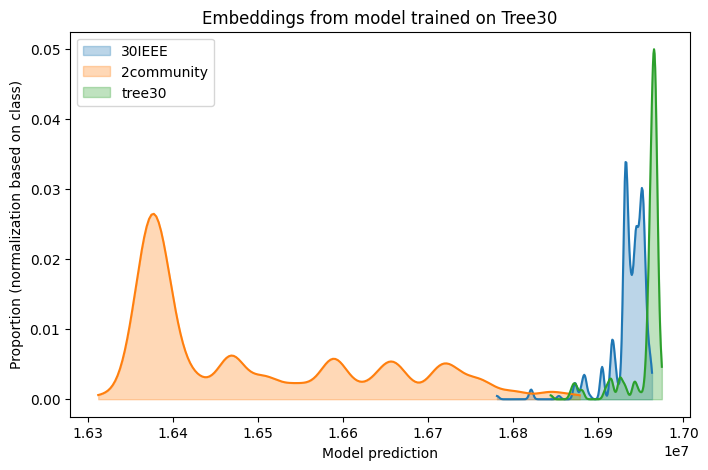

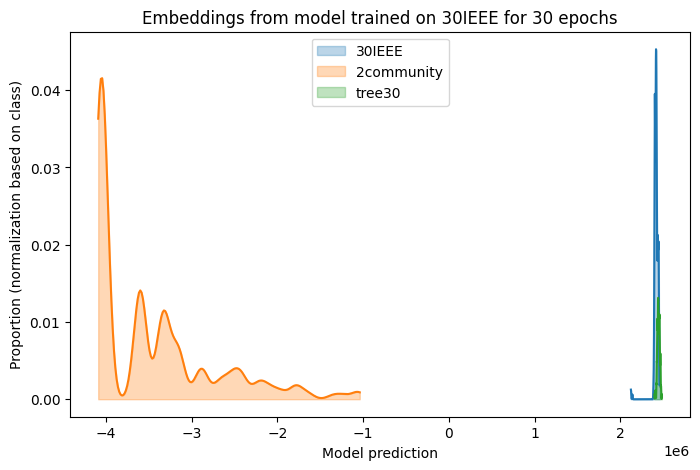

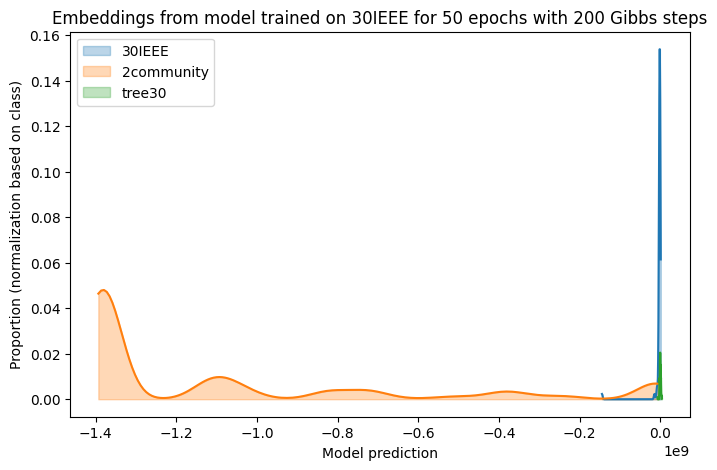

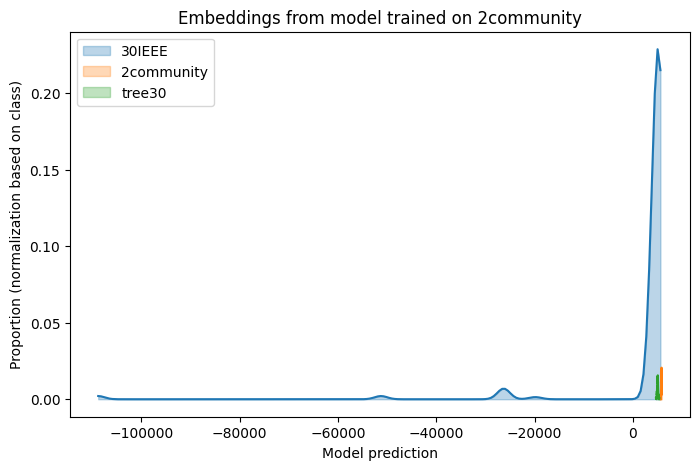

In [19]:
plot_embeddings(complessive_energy_model_tree, "Embeddings from model trained on Tree30")
plot_embeddings(complessive_energy_model_30IEEE_30epochs, "Embeddings from model trained on 30IEEE for 30 epochs")
plot_embeddings(complessive_energy_model_30IEEE_50epochs_200GS, "Embeddings from model trained on 30IEEE for 50 epochs with 200 Gibbs steps")
plot_embeddings(complessive_energy_model_2community, "Embeddings from model trained on 2community")


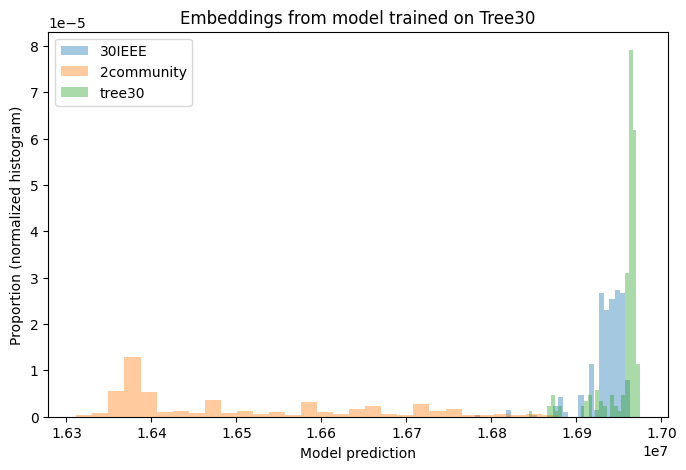

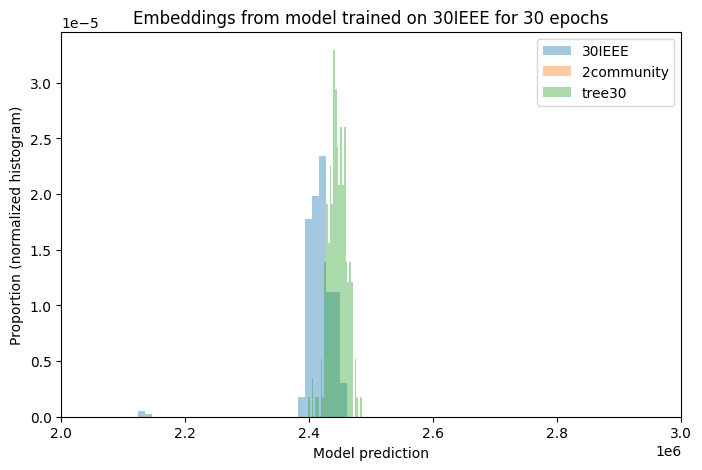

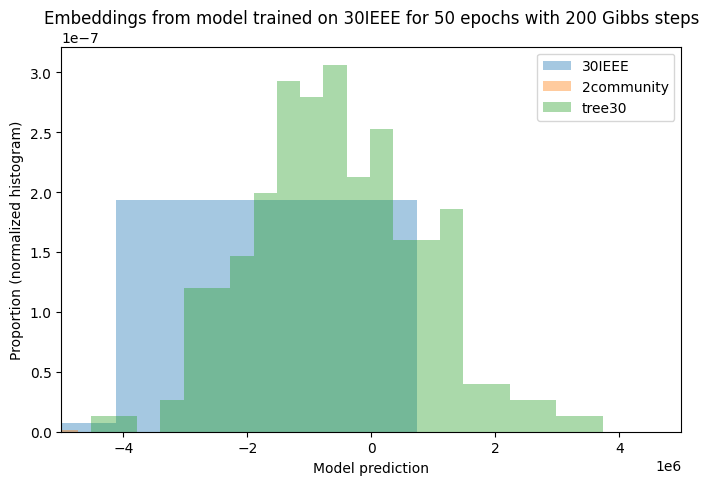

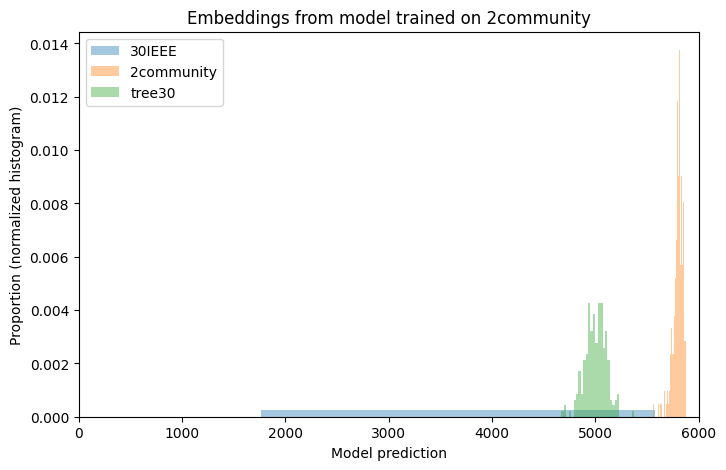

In [44]:
plot_embeddings_hist(complessive_energy_model_tree, "Embeddings from model trained on Tree30")
plot_embeddings_hist(complessive_energy_model_30IEEE_30epochs, "Embeddings from model trained on 30IEEE for 30 epochs", xlim=(2e6,3e6))
plot_embeddings_hist(complessive_energy_model_30IEEE_50epochs_200GS, "Embeddings from model trained on 30IEEE for 50 epochs with 200 Gibbs steps",xlim=(-0.5e7,0.5e7))
plot_embeddings_hist(complessive_energy_model_2community, "Embeddings from model trained on 2community" , xlim=(0,6000))

In [88]:
void_graph = nx.Graph()
fully_connected_graph = nx.complete_graph(30)
void_graph.add_nodes_from(range(30))

degenerate_dataset = GraphDataset([void_graph, fully_connected_graph])